In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
np.random.seed(0)
torch.manual_seed(0)

In [3]:
# Find GPU type on Google Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Apr 25 16:19:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 9912422/9912422 [00:00<00:00, 151119560.50it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 91699995.32it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32751280.51it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3945842.74it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
train_datasets = []
for i in range (10):
    # reduce datasets
    from torch.utils.data import Subset

    # train data
    train_idx = np.random.choice(60000, 4000)
    train_datasets.append(Subset(training_data, train_idx))

# test data
test_idx = np.random.choice(10000, 1000)
test_data = Subset(test_data, test_idx)

In [6]:
batch_size = 256
epochs = 1000
learning_rate = 1e-4

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")




Using cuda device


## Run on only 1 dataset
to get an idea of the reults in reasonable time

In [7]:
mean_layer_size_list = np.zeros(40)
mean_train_loss_list = np.zeros(40)
mean_test_loss_list = np.zeros(40)

print(f"********* Single Dataset ***********")
layer_size_list = []
train_loss_list = []
test_loss_list = []
# Create data loaders.
train_dataloader = DataLoader(train_datasets[0], batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for net_size in range(1,41):
    # Define model
    class NeuralNetwork(nn.Module):
        def __init__(self):
            super().__init__()
            self.flatten = nn.Flatten()
            self.linear_relu_stack = nn.Sequential(
                nn.Linear(28*28, net_size),
                nn.ReLU(),
                nn.Linear(net_size, 3),
                nn.ReLU(),
                nn.Linear(3, 3),
                nn.ReLU(),
                nn.Linear(3, 10)
            )

        def forward(self, x):
            x = self.flatten(x)
            logits = self.linear_relu_stack(x)
            return logits

    model = NeuralNetwork().to(device)
    # print(model)

    # define loss and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # define train function
    def train(dataloader, model, loss_fn, optimizer):
        size = len(dataloader.dataset)
        model.train()
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # if batch % 100 == 0:
            #     loss, current = loss.item(), (batch + 1) * len(X)
            #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        return loss.item()

    # define test function
    def test(dataloader, model, loss_fn):
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        model.eval()
        test_loss, correct = 0, 0
        with torch.no_grad():
            for X, y in dataloader:
                X, y = X.to(device), y.to(device)
                pred = model(X)
                test_loss += loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
        return test_loss

    # train!
    print('\n******* Middle layer size: {} **************\n'.format(net_size))
    for t in range(epochs):
        # print(f"Epoch {t+1}\n-------------------------------")
        train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss = test(test_dataloader, model, loss_fn)
    print(f"Train Loss: {train_loss:>8f} \n")
        
    layer_size_list.append(net_size)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    print("Done!")

# save stats
mean_layer_size_list += layer_size_list
mean_train_loss_list += train_loss_list
mean_test_loss_list += test_loss_list


********* Single Dataset ***********

******* Middle layer size: 1 **************

Test Error: 
 Accuracy: 25.2%, Avg loss: 1.797032 

Train Loss: 1.609770 

Done!

******* Middle layer size: 2 **************

Test Error: 
 Accuracy: 9.7%, Avg loss: 2.306349 

Train Loss: 2.298529 

Done!

******* Middle layer size: 3 **************

Test Error: 
 Accuracy: 49.5%, Avg loss: 1.371170 

Train Loss: 1.095858 

Done!

******* Middle layer size: 4 **************

Test Error: 
 Accuracy: 61.0%, Avg loss: 1.152800 

Train Loss: 0.906383 

Done!

******* Middle layer size: 5 **************

Test Error: 
 Accuracy: 73.8%, Avg loss: 0.927452 

Train Loss: 0.531797 

Done!

******* Middle layer size: 6 **************

Test Error: 
 Accuracy: 62.2%, Avg loss: 1.315370 

Train Loss: 0.882336 

Done!

******* Middle layer size: 7 **************

Test Error: 
 Accuracy: 53.6%, Avg loss: 1.382372 

Train Loss: 1.001556 

Done!

******* Middle layer size: 8 **************

Test Error: 
 Accuracy: 70.0%

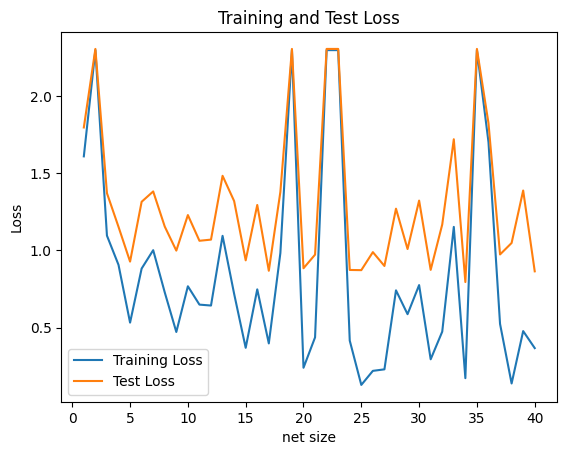

In [8]:
# Plot the training and test loss.
import matplotlib.pyplot as plt
x = np.arange(0, epochs, 1)
plt.title('Training and Test Loss')
plt.xlabel('net size')
plt.ylabel('Loss')
plt.plot(layer_size_list, mean_train_loss_list, label='Training Loss')
plt.plot(layer_size_list, mean_test_loss_list, label='Test Loss')
plt.legend()
plt.show()

## Run on all datasets
### Changing First Layer

In [ ]:
mean_layer_size_list = np.zeros(40)
mean_train_loss_list = np.zeros(40)
mean_test_loss_list = np.zeros(40)

for j in range (10):
    print(f"********* Dataset Number {j} ***********")
    layer_size_list = []
    train_loss_list = []
    test_loss_list = []
    # Create data loaders.
    train_dataloader = DataLoader(train_datasets[j], batch_size=batch_size)
    test_dataloader = DataLoader(test_data, batch_size=batch_size)

    for net_size in range(1,41):
        # Define model
        class NeuralNetwork(nn.Module):
            def __init__(self):
                super().__init__()
                self.flatten = nn.Flatten()
                self.linear_relu_stack = nn.Sequential(
                    nn.Linear(28*28, net_size),
                    nn.ReLU(),
                    nn.Linear(net_size, 3),
                    nn.ReLU(),
                    nn.Linear(3, 3),
                    nn.ReLU(),
                    nn.Linear(3, 10)
                )

            def forward(self, x):
                x = self.flatten(x)
                logits = self.linear_relu_stack(x)
                return logits

        model = NeuralNetwork().to(device)
        # print(model)

        # define loss and optimizer
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # define train function
        def train(dataloader, model, loss_fn, optimizer):
            size = len(dataloader.dataset)
            model.train()
            for batch, (X, y) in enumerate(dataloader):
                X, y = X.to(device), y.to(device)

                # Compute prediction error
                pred = model(X)
                loss = loss_fn(pred, y)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # if batch % 100 == 0:
                #     loss, current = loss.item(), (batch + 1) * len(X)
                #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            return loss.item()

        # define test function
        def test(dataloader, model, loss_fn):
            size = len(dataloader.dataset)
            num_batches = len(dataloader)
            model.eval()
            test_loss, correct = 0, 0
            with torch.no_grad():
                for X, y in dataloader:
                    X, y = X.to(device), y.to(device)
                    pred = model(X)
                    test_loss += loss_fn(pred, y).item()
                    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            test_loss /= num_batches
            correct /= size
            print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
            return test_loss

        # train!
        print('\n******* Middle layer size: {} **************\n'.format(net_size))
        for t in range(epochs):
            # print(f"Epoch {t+1}\n-------------------------------")
            train_loss = train(train_dataloader, model, loss_fn, optimizer)
        test_loss = test(test_dataloader, model, loss_fn)
        print(f"Train Loss: {train_loss:>8f} \n")
        
        layer_size_list.append(net_size)
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        print("Done!")

    # save stats
    mean_layer_size_list += layer_size_list
    mean_train_loss_list += train_loss_list
    mean_test_loss_list += test_loss_list

mean_layer_size_list /= 10
mean_train_loss_list /= 10
mean_test_loss_list /= 10

********* Dataset Number 0 ***********

******* Middle layer size: 1 **************

Test Error: 
 Accuracy: 19.5%, Avg loss: 1.915899 

Train Loss: 1.694034 

Done!

******* Middle layer size: 2 **************

Test Error: 
 Accuracy: 54.9%, Avg loss: 1.273895 

Train Loss: 0.924763 

Done!

******* Middle layer size: 3 **************

Test Error: 
 Accuracy: 58.6%, Avg loss: 1.235667 

Train Loss: 0.892924 

Done!

******* Middle layer size: 4 **************

Test Error: 
 Accuracy: 17.6%, Avg loss: 2.012107 

Train Loss: 1.806713 

Done!

******* Middle layer size: 5 **************

Test Error: 
 Accuracy: 61.7%, Avg loss: 1.203472 

Train Loss: 0.771870 

Done!

******* Middle layer size: 6 **************

Test Error: 
 Accuracy: 54.7%, Avg loss: 1.335634 

Train Loss: 0.926820 

Done!

******* Middle layer size: 7 **************

Test Error: 
 Accuracy: 9.7%, Avg loss: 2.306369 

Train Loss: 2.298496 

Done!

******* Middle layer size: 8 **************

Test Error: 
 Accuracy: 58.

In [ ]:
# Plot the training and test loss.
import matplotlib.pyplot as plt
x = np.arange(0, epochs, 1)
plt.title('Training and Test Loss  1st layer')
plt.xlabel('net size')
plt.ylabel('Loss')
plt.plot(layer_size_list, mean_train_loss_list, label='Training Loss')
plt.plot(layer_size_list, mean_test_loss_list, label='Test Loss')
plt.legend()
plt.show()

### Changing Second Layer

In [ ]:
mean_layer_size_list = np.zeros(40)
mean_train_loss_list = np.zeros(40)
mean_test_loss_list = np.zeros(40)

for j in range (10):
    print(f"********* Dataset Number {j} ***********")
    layer_size_list = []
    train_loss_list = []
    test_loss_list = []
    # Create data loaders.
    train_dataloader = DataLoader(training_data, batch_size=batch_size)
    test_dataloader = DataLoader(test_data, batch_size=batch_size)

    for net_size in range(1,41):
        # Define model
        class NeuralNetwork(nn.Module):
            def __init__(self):
                super().__init__()
                self.flatten = nn.Flatten()
                self.linear_relu_stack = nn.Sequential(
                    nn.Linear(28*28, 3),
                    nn.ReLU(),
                    nn.Linear(3, net_size),
                    nn.ReLU(),
                    nn.Linear(net_size, 3),
                    nn.ReLU(),
                    nn.Linear(3, 10)
                )

            def forward(self, x):
                x = self.flatten(x)
                logits = self.linear_relu_stack(x)
                return logits

        model = NeuralNetwork().to(device)
        # print(model)

        # define loss and optimizer
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

        # define train function
        def train(dataloader, model, loss_fn, optimizer):
            size = len(dataloader.dataset)
            model.train()
            for batch, (X, y) in enumerate(dataloader):
                X, y = X.to(device), y.to(device)

                # Compute prediction error
                pred = model(X)
                loss = loss_fn(pred, y)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # if batch % 100 == 0:
                #     loss, current = loss.item(), (batch + 1) * len(X)
                #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            return loss.item()

        # define test function
        def test(dataloader, model, loss_fn):
            size = len(dataloader.dataset)
            num_batches = len(dataloader)
            model.eval()
            test_loss, correct = 0, 0
            with torch.no_grad():
                for X, y in dataloader:
                    X, y = X.to(device), y.to(device)
                    pred = model(X)
                    test_loss += loss_fn(pred, y).item()
                    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            test_loss /= num_batches
            correct /= size
            print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
            return test_loss

        # train!
        print('\n******* Middle layer size: {} **************\n'.format(net_size))
        for t in range(epochs):
            # print(f"Epoch {t+1}\n-------------------------------")
            train_loss = train(train_dataloader, model, loss_fn, optimizer)
        test_loss = test(test_dataloader, model, loss_fn)
        
        layer_size_list.append(net_size)
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        print("Done!")

    # save stats
    mean_layer_size_list += layer_size_list
    mean_train_loss_list += train_loss_list
    mean_test_loss_list += test_loss_list

mean_layer_size_list /= 10
mean_train_loss_list /= 10
mean_test_loss_list /= 10

In [ ]:
# Plot the training and test loss.
import matplotlib.pyplot as plt
x = np.arange(0, epochs, 1)
plt.title('Training and Test Loss 2nd layer')
plt.xlabel('net size')
plt.ylabel('Loss')
plt.plot(layer_size_list, mean_train_loss_list, label='Training Loss')
plt.plot(layer_size_list, mean_test_loss_list, label='Test Loss')
plt.legend()
plt.show()

### Changing Third Layer

In [ ]:
mean_layer_size_list = np.zeros(40)
mean_train_loss_list = np.zeros(40)
mean_test_loss_list = np.zeros(40)

for j in range (10):
    print(f"********* Dataset Number {j} ***********")
    layer_size_list = []
    train_loss_list = []
    test_loss_list = []
    # Create data loaders.
    train_dataloader = DataLoader(training_data, batch_size=batch_size)
    test_dataloader = DataLoader(test_data, batch_size=batch_size)

    for net_size in range(1,41):
        # Define model
        class NeuralNetwork(nn.Module):
            def __init__(self):
                super().__init__()
                self.flatten = nn.Flatten()
                self.linear_relu_stack = nn.Sequential(
                    nn.Linear(28*28, 3),
                    nn.ReLU(),
                    nn.Linear(3, 3),
                    nn.ReLU(),
                    nn.Linear(3, net_size),
                    nn.ReLU(),
                    nn.Linear(net_size, 10)
                )

            def forward(self, x):
                x = self.flatten(x)
                logits = self.linear_relu_stack(x)
                return logits

        model = NeuralNetwork().to(device)
        # print(model)

        # define loss and optimizer
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

        # define train function
        def train(dataloader, model, loss_fn, optimizer):
            size = len(dataloader.dataset)
            model.train()
            for batch, (X, y) in enumerate(dataloader):
                X, y = X.to(device), y.to(device)

                # Compute prediction error
                pred = model(X)
                loss = loss_fn(pred, y)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # if batch % 100 == 0:
                #     loss, current = loss.item(), (batch + 1) * len(X)
                #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            return loss.item()

        # define test function
        def test(dataloader, model, loss_fn):
            size = len(dataloader.dataset)
            num_batches = len(dataloader)
            model.eval()
            test_loss, correct = 0, 0
            with torch.no_grad():
                for X, y in dataloader:
                    X, y = X.to(device), y.to(device)
                    pred = model(X)
                    test_loss += loss_fn(pred, y).item()
                    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            test_loss /= num_batches
            correct /= size
            print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
            return test_loss

        # train!
        print('\n******* Middle layer size: {} **************\n'.format(net_size))
        for t in range(epochs):
            # print(f"Epoch {t+1}\n-------------------------------")
            train_loss = train(train_dataloader, model, loss_fn, optimizer)
        test_loss = test(test_dataloader, model, loss_fn)
        
        layer_size_list.append(net_size)
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        print("Done!")

    # save stats
    mean_layer_size_list += layer_size_list
    mean_train_loss_list += train_loss_list
    mean_test_loss_list += test_loss_list

mean_layer_size_list /= 10
mean_train_loss_list /= 10
mean_test_loss_list /= 10

In [ ]:
# Plot the training and test loss.
import matplotlib.pyplot as plt
x = np.arange(0, epochs, 1)
plt.title('Training and Test Loss 3rd layer')
plt.xlabel('net size')
plt.ylabel('Loss')
plt.plot(layer_size_list, mean_train_loss_list, label='Training Loss')
plt.plot(layer_size_list, mean_test_loss_list, label='Test Loss')
plt.legend()
plt.show()